# Testing of the Backtesting Environment

In [ ]:
import sys
# setting path
sys.path.append("C:/Users/abderrahim.namouh/Documents/OneDrive - Mazars/Projet/uniswap-v3")  # Edit your path
import numpy as np
import pandas as pd
from Strat_backtesting_env import LiquidityPool
import matplotlib.pyplot as plt

## LP's strategy simulation

### Data preparation

In [2]:
LP_id = '0x86426AD2B71f41a5d545E5e2F63c76913D93E1A5'

# Data load
contract = pd.read_csv('../../total_historical_swaps.csv', index_col=0)
contract['timestamp'] = pd.to_datetime(contract['timestamp'])
mints = pd.read_csv("../../historical_mints.csv")
burns = pd.read_csv("../../historical_burns.csv")
collects = pd.read_csv("../../historical_collects.csv")

mints['timestamp'] = pd.to_datetime(mints['timestamp'])
burns['timestamp'] = pd.to_datetime(burns['timestamp'])
collects['timestamp'] = pd.to_datetime(collects['timestamp'])

contract['liquidity'] = contract['liquidity'].astype(float)/(10**12)
mints['liquidity'] = mints['liquidity'].astype(float)/(10**12)
burns['liquidity'] = burns['liquidity'].astype(float)/(10**12)

# Filter to get the LP
lp_mints = mints[mints['owner']==LP_id][['timestamp','tickLower', 'tickUpper','liquidity', 'amount0', 'amount1']]
lp_burns = burns[burns['owner']==LP_id][['timestamp','tickLower', 'tickUpper','liquidity', 'amount0', 'amount1']]
lp_collects = collects[collects['owner']==LP_id][['timestamp','tickLower', 'tickUpper', 'amount0', 'amount1']]

start_ts, end_ts = pd.concat([lp_mints, lp_burns, lp_collects]).sort_values(by='timestamp').timestamp.min(), pd.concat([lp_mints, lp_burns, lp_collects]).sort_values(by='timestamp').timestamp.max()
start_ts, end_ts = contract[contract.timestamp < start_ts].timestamp.max(), contract[contract.timestamp > end_ts].timestamp.min()
lp_prices = contract[(contract.timestamp >= start_ts)&(contract.timestamp <= end_ts)][['timestamp','price']]

# Categorize events
lp_mints['type'] = 'mint'
lp_burns['type'] = 'burn'
lp_prices['type'] = 'pool'
lp_collects['type'] = 'collect'

# Concat and convert ticks format
history_ops = pd.concat([lp_prices, lp_mints, lp_burns, lp_collects ]).sort_values(by='timestamp').reset_index(drop=True)
history_ops['tickLower'] = 10**12/(1.0001**history_ops['tickLower'])
history_ops['tickUpper'] = 10**12/(1.0001**history_ops['tickUpper'])

### Launch the simulation

In [3]:
test = history_ops

### Initialize the pool

In [4]:
initial_price, fee_tier = test.price.iloc[0], 0.05

pool = LiquidityPool(initial_price, fee_tier, silence_mode=True)

In [5]:
timestamps = dict()
initials = [dict(),dict()]
final_values = [dict(),dict()]
prices = dict()

print("Operations:")
f_0, f_1 = 0,0
for i in range(len(test)):
    if test.loc[i,'type'] == 'pool':
        pool.swap_price(test.loc[i,'price'])
    else:
        # in the ETH/USDC pov, the lower/upper ticks are the upper/lower one in the USDC/ETH pov
        if test.loc[i,'type'] == 'mint':
            f0, f1 = pool.add_position_liquidity(test.loc[i,'tickUpper'],test.loc[i,'tickLower'],test.loc[i,'liquidity'])
            ini0, ini1 =  initials[0].get((test.loc[i,'tickUpper'],test.loc[i,'tickLower']),(0,0))
            initials[0][(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = tuple(a+b for a,b in zip(pool.get_position_comp(test.loc[i,'tickUpper'],test.loc[i,'tickLower']), (ini0,ini1)))
            ini0, ini1 =  initials[1].get((test.loc[i,'tickUpper'],test.loc[i,'tickLower']),(0,0))
            initials[1][(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = tuple(a+b for a,b in zip((test.loc[i,'amount1'],test.loc[i,'amount0']), (ini0,ini1)))
            f_0 += f0
            f_1 += f1

        elif test.loc[i,'type'] == 'burn':
            ((token0, token1)), f0, f1 = pool.burn_liquidity(test.loc[i,'tickUpper'],test.loc[i,'tickLower'],test.loc[i,'liquidity'])
            final_value = (token0 * pool.current_price + token1)
            final_values[0][(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = final_values[0].get((test.loc[i,'tickUpper'],test.loc[i,'tickLower']),0) + (final_value + f0 * test.loc[i-1,'price'] + f1)
            prices[(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = test.loc[i-1,'price']
            timestamps[(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = test.loc[i,'timestamp']
            f_0 += f0
            f_1 += f1

        elif test.loc[i,'type'] == 'collect':
            final_value = test.loc[i,'amount1'] * pool.current_price + test.loc[i,'amount0']
            final_values[1][(test.loc[i,'tickUpper'],test.loc[i,'tickLower'])] = final_values[1].get((test.loc[i,'tickUpper'],test.loc[i,'tickLower']),0) + final_value 


Operations:


In [6]:
true_final_values = final_values[1]
env_final_values = final_values[0]
true_initials = initials[1]
env_initials = initials[0]
prices = dict(sorted(prices.items()))
true_final_values = dict(sorted(true_final_values.items()))
true_initials = dict(sorted(true_initials.items()))
env_final_values = dict(sorted(env_final_values.items()))
env_initials = dict(sorted(env_initials.items()))
timestamps = dict(sorted(timestamps.items()))
env_returns = [(f-(i1+p*i0))/(i1+p*i0) for f,p,(i0,i1) in zip(env_final_values.values(), prices.values(), env_initials.values())]
true_returns = [(f-(i1+p*i0))/(i1+p*i0) for f,p,(i0,i1) in zip(true_final_values.values(), prices.values(), true_initials.values())]

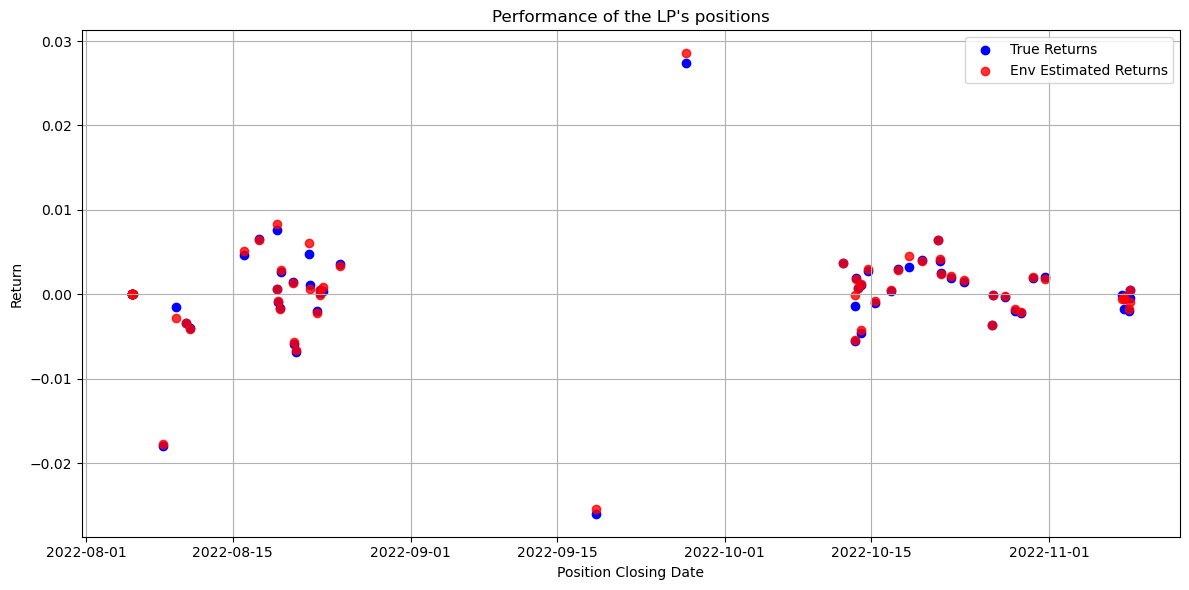

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(timestamps.values(), true_returns, marker='o', linestyle='-', color='b', label='True Returns')
plt.scatter(timestamps.values(), env_returns, marker='o', linestyle='-', color='r', alpha=0.8, label='Env Estimated Returns')
plt.xlabel('Position Closing Date')
plt.ylabel('Return')
plt.title("Performance of the LP's positions")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [8]:
env_results = pd.DataFrame({'timestamp' : timestamps.values(), 'return': env_returns})
true_results = pd.DataFrame({'timestamp' : timestamps.values(), 'return': true_returns})

In [9]:
env_results.sort_values(by='timestamp', inplace=True)
env_results.reset_index(inplace=True)
true_results.sort_values(by='timestamp', inplace=True)
true_results.reset_index(inplace=True)

In [10]:
print(f"Relative Error on the Simulated Returned rel. to the Epirical Return: {100*round((np.sqrt((2*(true_results['return']-env_results['return'])/(true_results['return']+env_results['return']))**2)).mean(), 4)}%")

Relative Error on the Simulated Returned rel. to the Epirical Return: 26.97%


In [11]:
print(f"Relative Error on the Simulated Returned rel. to the Epirical Return: {100*round((np.sqrt((2*(true_results['return']-env_results['return'])/(true_results['return']+env_results['return']))**2)).mean(), 4)}%")

Relative Error on the Simulated Returned rel. to the Epirical Return: 26.97%


### Gained fees

In [13]:
collects = pd.read_csv('../../historical_collects.csv')
collects['timestamp'] = pd.to_datetime(collects['timestamp'])
collects['Day'] = collects.timestamp.dt.date
collects.head()

,block_number,timestamp,owner,tickLower,tickUpper,amount0,amount1,Day
0,15000223,2022-06-21 03:29:10,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,201940,208300,10220.925428,8.906536,2022-06-21
1,15000227,2022-06-21 03:30:35,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,201940,208300,91228.646008,151.583922,2022-06-21
2,15000413,2022-06-21 04:22:07,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,205490,206540,92027.937964,109.012750,2022-06-21
3,15000685,2022-06-21 05:26:45,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,201960,208200,20246.439939,29.883500,2022-06-21
4,15000702,2022-06-21 05:31:43,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,207650,207860,199999.999999,0.000000,2022-06-21


In [14]:
acc_fees = collects[collects['owner']==LP_id][['amount0','amount1']] .reset_index(drop=True)
acc_fees['amount0'] =  acc_fees['amount0'] - lp_burns['amount0'].reset_index(drop=True)
acc_fees['amount1'] =  acc_fees['amount1'] - lp_burns['amount1'].reset_index(drop=True)
x,y = acc_fees.sum()
print(f"The LP earned the following fees: {y} ETH and {x} USDC")
print(f"According to the backtesting env, the LP earned the following fees: {f_0} ETH and {f_1} USDC")

The LP earned the following fees: 6.613823109931955 ETH and 9185.492009999984 USDC
According to the backtesting env, the LP earned the following fees: 6.808735627550796 ETH and 9451.067773791803 USDC
